<a href="https://colab.research.google.com/github/dralvima/IITmethods/blob/main/updated_edf_EEG_POWER_to_PHI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using IIT4 to study EEG files (in EDF) format

## 1. LOAD DATA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.6 MB/s eta 0:00:00


Saving assr4.2_26_40clicks.edf to assr4.2_26_40clicks.edf
Uploaded file: assr4.2_26_40clicks.edf
Extracting EDF parameters from /content/assr4.2_26_40clicks.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 229375  =      0.000 ...   223.999 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: FC1, C1, Pz, CPz, Fz, FC2, FCz, Cz, C2
 chs: 9 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2017-12-02 06:27:01 UTC
 nchan: 9
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 3 items (dict)
>
Using matplotlib as 2D backend.


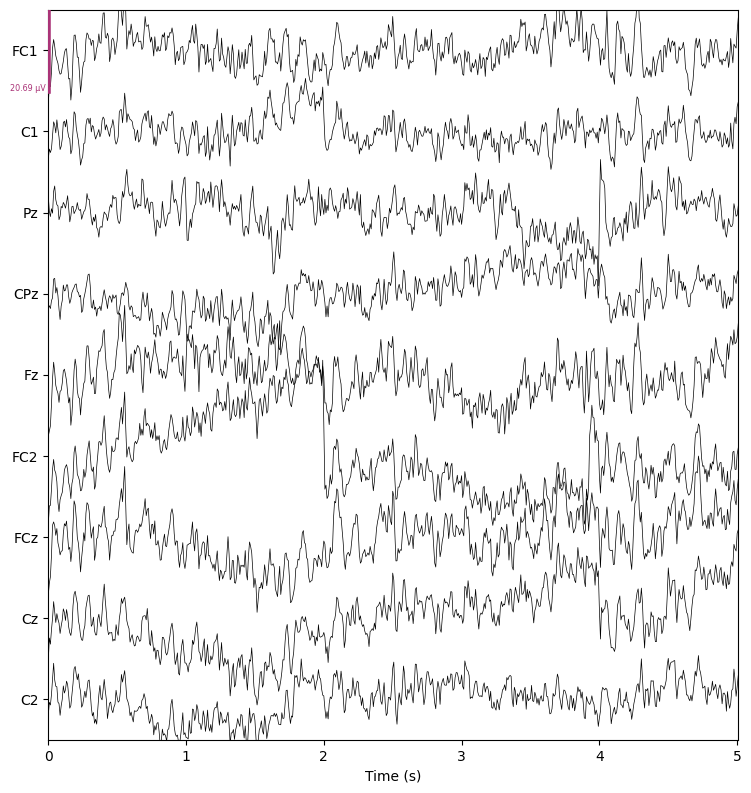

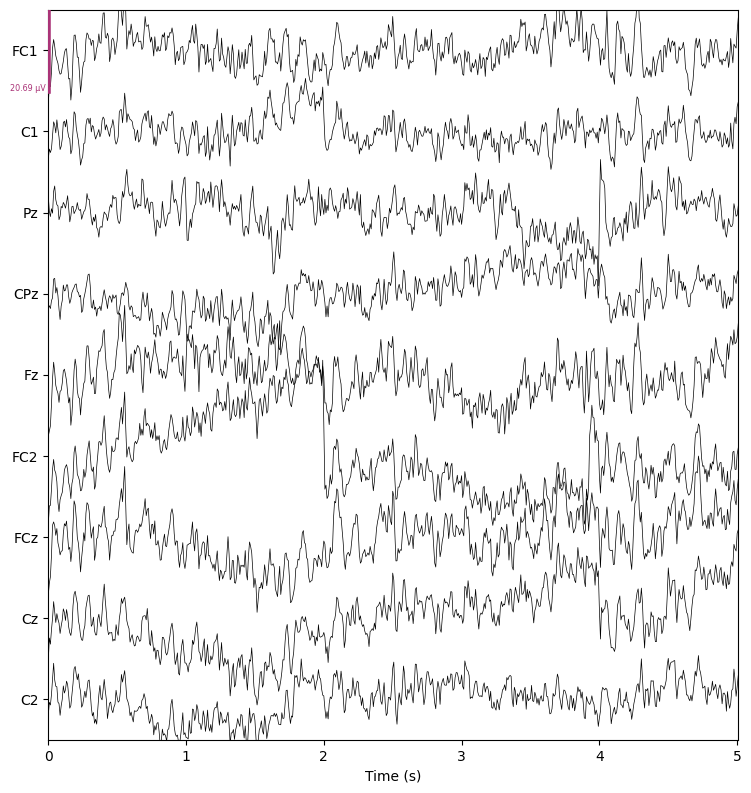

In [ ]:
!pip install mne
import mne
from google.colab import files

# Step 1: Prompt to upload the file
uploaded = files.upload()

# Step 2: Ensure the file is correctly uploaded
file_name = list(uploaded.keys())[0]
print(f"Uploaded file: {file_name}")

# Step 3: Load the EDF file using MNE
raw = mne.io.read_raw_edf(file_name, preload=True)

# Step 4: Display basic information about the EEG data
print(raw.info)

# Step 5: Downsample the data to reduce the load (optional, but recommended if data is large)
raw.resample(sfreq=128, npad="auto")  # Resample to 128 Hz

# Step 6: Plot only a small segment to avoid browser overload
raw.plot(duration=5, n_channels=10, scalings='auto', show_scrollbars=False)  # Plot 5 seconds and 10 channels

## 2. BINARIZE THE DATA (USING MEDIAN)

### SUB-SELECT CHANNELS TO RUN ANALYSIS ON (let's do 3 for now - we can scale that up to 4 or even 5 later)

In [ ]:
import mne
import numpy as np
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, clear_output

# Get the list of available channels
channels = raw.info['ch_names']

# Create a dropdown widget to select 3 channels
channel_selector = widgets.SelectMultiple(
    options=channels,
    value=[channels[0], channels[1], channels[2]],
    rows=len(channels),
    description='Channels',
    disabled=False
)

# Create a button to confirm the selection
confirm_button = widgets.Button(description="Confirm Selection")

# Display the widgets
display(channel_selector)
display(confirm_button)

# Function to handle the button click event
def on_button_click(b):
    global selected_channels
    selected_channels = channel_selector.value
    if len(selected_channels) == 3:
        print(f"Selected channels: {selected_channels}")
        # Save the selected channels
        np.save('/content/selected_channels.npy', selected_channels)
    else:
        print("Please select exactly 3 channels.")
    clear_output()
    display(channel_selector)
    display(confirm_button)

# Attach the button click event to the handler
confirm_button.on_click(on_button_click)

SelectMultiple(description='Channels', index=(0, 6, 8), options=('FC1', 'C1', 'Pz', 'CPz', 'Fz', 'FC2', 'FCz',…

Button(description='Confirm Selection', style=ButtonStyle())

### PLOT THE BINARIZED DATA

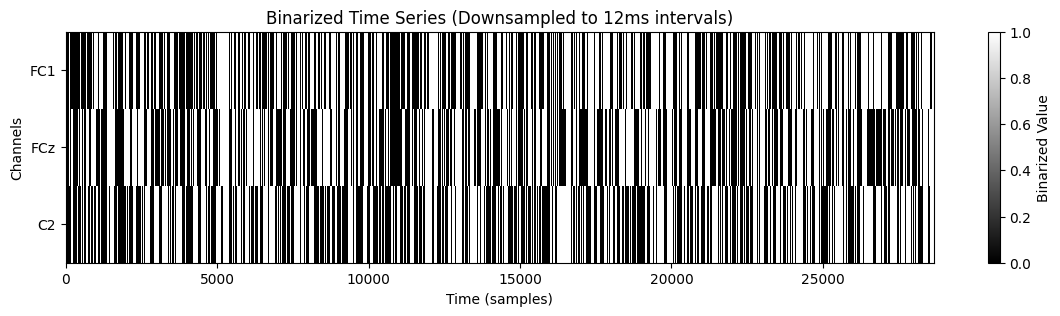

In [ ]:
import matplotlib.pyplot as plt

# Extract the data for the selected channels
picks = mne.pick_channels(raw.info['ch_names'], include=selected_channels)
data, times = raw[picks, :]

# Full-wave rectify the data (absolute value)
rectified_data = np.abs(data)

# Compute the power of the rectified signal (power = rectified signal squared)
power_data = rectified_data ** 2

# Binarize the power data
binarized_data = np.zeros_like(power_data, dtype=int)
for i in range(power_data.shape[0]):
    median = np.median(power_data[i])
    binarized_data[i] = np.where(power_data[i] > median, 1, 0)
    median_indices = power_data[i] == median
    binarized_data[i, median_indices] = np.random.randint(0, 2, size=median_indices.sum())

# Plot the binarized time series
plt.figure(figsize=(14, 3))
plt.imshow(binarized_data, aspect='auto', cmap='gray', interpolation='none')
plt.title("Binarized Time Series (Downsampled to 12ms intervals)")
plt.xlabel("Time (samples)")
plt.ylabel("Channels")
plt.yticks(ticks=np.arange(len(selected_channels)), labels=selected_channels)
plt.colorbar(label='Binarized Value')
plt.show()

### Combine those three binarized time series into a single 3-bit sequence as a function of time

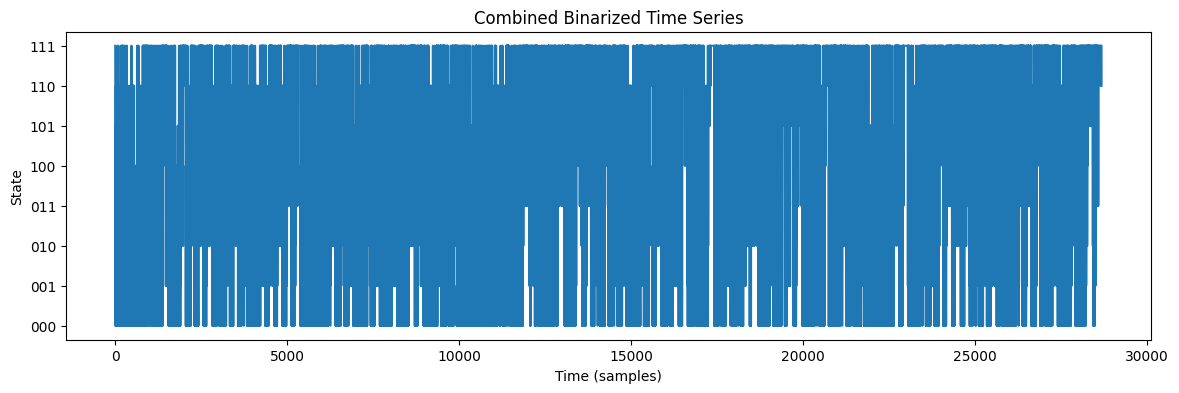

In [ ]:
# Combine the binarized time series into a single time series of 3 bits per sample
combined_series = np.zeros(binarized_data.shape[1], dtype=int)
for i in range(binarized_data.shape[1]):
    combined_series[i] = int(''.join(map(str, binarized_data[:, i].astype(int))), 2)

# Define the y-axis labels for the binary states
binary_states = [format(i, '03b') for i in range(8)]

# Plot the combined time series
plt.figure(figsize=(14, 4))
plt.plot(combined_series)
plt.title("Combined Binarized Time Series")
plt.xlabel("Time (samples)")
plt.ylabel("State")
plt.yticks(ticks=np.arange(8), labels=binary_states)
plt.show()

## 3. CREATE TPM

In [ ]:
import numpy as np
from itertools import product

def generate_states(num_bits):
    """Generate all possible states for a given number of bits in little-endian order."""
    states = list(product([0, 1], repeat=num_bits))
    states = sorted(states, key=lambda x: sum([bit << i for i, bit in enumerate(x)]))
    return states

def state_to_index(state, states):
    """Convert a state to its index based on the list of states."""
    return states.index(tuple(state))

def compute_tpm(time_series, num_bits):
    """Compute the transition probability matrix (TPM) for the given time series."""
    global states
    states = generate_states(num_bits)
    num_states = len(states)
    tpm = np.zeros((num_states, num_states))

    for i in range(len(time_series) - 1):
        current_state = list(map(int, bin(time_series[i])[2:].zfill(num_bits)))
        next_state = list(map(int, bin(time_series[i + 1])[2:].zfill(num_bits)))

        current_index = state_to_index(current_state, states)
        next_index = state_to_index(next_state, states)

        tpm[current_index, next_index] += 1

    # Normalize the TPM
    tpm = tpm / tpm.sum(axis=1, keepdims=True)
    return tpm

num_bits = 3  # Change this to the number of bits you are analyzing

tpm = compute_tpm(combined_series, num_bits)
print("Transition Probability Matrix (TPM):")
print(tpm)

Transition Probability Matrix (TPM):
[[0.60868868 0.10003206 0.07101635 0.0453671  0.10436037 0.02228278
  0.02596986 0.02228278]
 [0.24853311 0.38851635 0.03562448 0.10100587 0.05322716 0.10477787
  0.01718357 0.0511316 ]
 [0.18859649 0.0372807  0.42105263 0.14736842 0.04122807 0.01315789
  0.1        0.05131579]
 [0.08831245 0.07286505 0.08918683 0.51675896 0.01748761 0.01777907
  0.02827164 0.16933839]
 [0.20258223 0.03934829 0.0288964  0.02735936 0.45127575 0.11035967
  0.0826929  0.0574854 ]
 [0.06669378 0.09394063 0.01179341 0.02724685 0.1447743  0.46929646
  0.03212688 0.15412769]
 [0.05497076 0.01325536 0.08810916 0.03664717 0.10214425 0.03001949
  0.47251462 0.20233918]
 [0.0249216  0.01765968 0.02261099 0.09060901 0.03878528 0.06420201
  0.07872586 0.66248556]]


plot the TPM in 2D as a sanity check

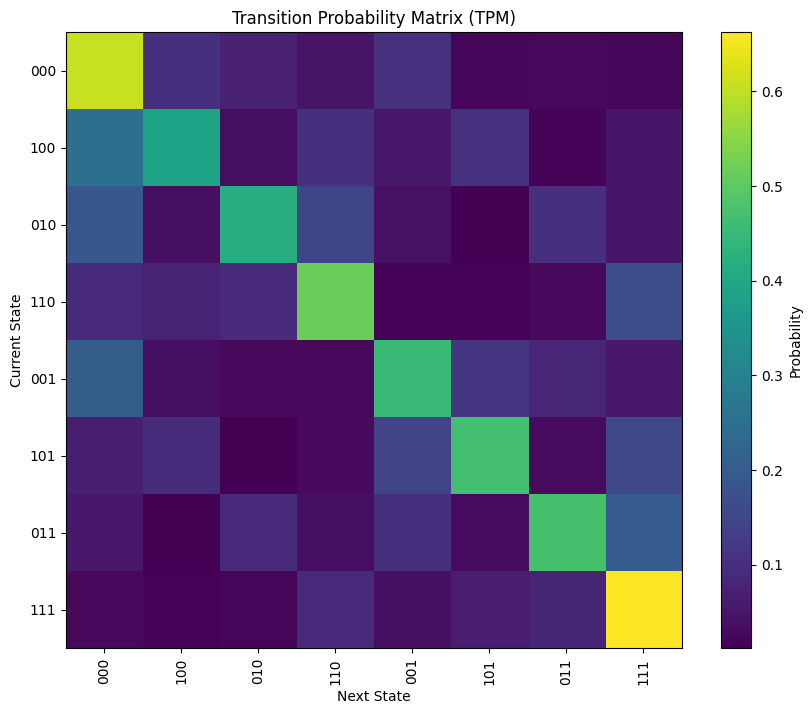

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

def plot_tpm(tpm, states):
    """Plot the Transition Probability Matrix (TPM)."""
    plt.figure(figsize=(10, 8))
    plt.imshow(tpm, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Probability')
    plt.title('Transition Probability Matrix (TPM)')
    plt.xlabel('Next State')
    plt.ylabel('Current State')
    plt.xticks(ticks=np.arange(len(states)), labels=[''.join(map(str, state)) for state in states], rotation=90)
    plt.yticks(ticks=np.arange(len(states)), labels=[''.join(map(str, state)) for state in states])
    plt.show()

# Plot the TPM
plot_tpm(tpm, states)

# 4. COMPUTE PHI AND CES

## Install PYPHI

In [ ]:
!pip install -U git+https://github.com/wmayner/pyphi.git@feature/iit-4.0
import itertools
import pyphi
# Disable PyPhi progress bars and welcome message
pyphi.config.PROGRESS_BARS = False
pyphi.config.WELCOME_OFF = True

  Cloning https://github.com/wmayner/pyphi.git (to revision feature/iit-4.0) to /tmp/pip-req-build-e4i82_jk
  Running command git clone --filter=blob:none --quiet https://github.com/wmayner/pyphi.git /tmp/pip-req-build-e4i82_jk
  Resolved https://github.com/wmayner/pyphi.git to commit 64055cc75f93504557ecccd1b446c9f1d6604594
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.6/662.6 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 21.3 MB/s eta 0:00:00
     ━━━━━

## Hand over TPM to PyPhi and compute PHI values

In [ ]:
import pyphi
import itertools
import numpy as np
import pickle

# Setting up the required parameters for pyPhi analysis
labels = ('A', 'B', 'C')
num_bits = len(labels)
possible_states = np.array(list(itertools.product([0, 1], repeat=num_bits)))

converted_tpm = pyphi.convert.sbs2sbn(tpm)
network = pyphi.Network(converted_tpm, node_labels=labels)
node_indices = (0, 1, 2)

# Function to calculate phi values and states for a single TPM
def calculate_phi_for_tpm(tpm, possible_states, labels):
    converted_tpm = pyphi.convert.sbs2sbn(tpm)
    network = pyphi.Network(converted_tpm, node_labels=labels)
    node_indices = (0, 1, 2)

    phi_values = np.zeros(len(possible_states))
    phi_states = np.zeros((len(possible_states), 3), dtype=int)

    max_phi = -np.inf
    max_phi_state = None

    for i, state in enumerate(possible_states):
            candidate_system = pyphi.Subsystem(network, state, node_indices)
            phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
            big_phi = phi_structure.big_phi
            phi_values[i] = big_phi
            phi_states[i] = state
            if big_phi > max_phi:
                max_phi = big_phi
                max_phi_state = state


    return phi_values, phi_states, max_phi, max_phi_state

phi_values, phi_states, max_phi, max_phi_state = calculate_phi_for_tpm(tpm, possible_states, labels)

2024-06-26 07:53:48,428	INFO worker.py:1761 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


## PLOT THE PHI VALUES OF ALL POSSIBLE STATES

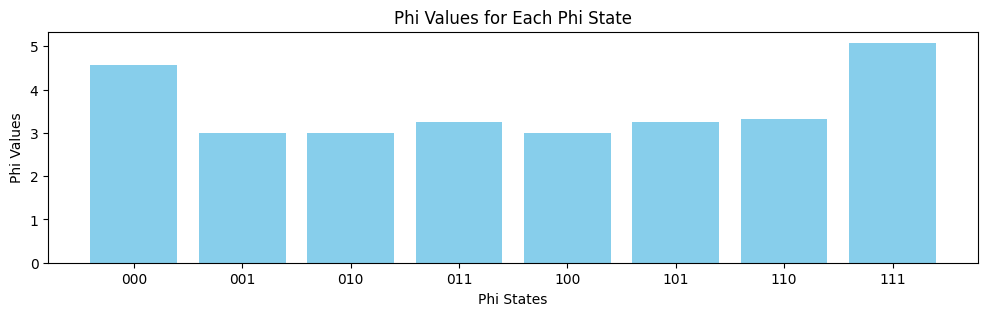

Max Phi: 5.083296001239547
State with Max Phi: [1 1 1]


In [ ]:
import matplotlib.pyplot as plt

phi_states = ['000', '001', '010', '011', '100', '101', '110', '111']

# Create a bar plot
plt.figure(figsize=(12, 3))
plt.bar(phi_states, phi_values, color='skyblue')

# Add title and labels
plt.title('Phi Values for Each Phi State')
plt.xlabel('Phi States')
plt.ylabel('Phi Values')

# Show the plot
plt.show()

# Display results
print("Max Phi:", max_phi)
print("State with Max Phi:", max_phi_state)

## **compute & plot the CES**

In [ ]:
substrate = pyphi.Network(converted_tpm, node_labels=labels)
# Pick the Max Phi state (YOU CAN MANUALLY CHANGE THIS TO LOOK AT ANY POSSIBLE STATE YOU LIKE!!!)
substrate_state = (max_phi_state)
# units are python indexed, 0 is node A, 1 is node B, 2 is node C
candidate_complex_units = (0,1,2)
candidate_cause_complex = pyphi.Subsystem(substrate, substrate_state, nodes=candidate_complex_units)
candidate_effect_complex = pyphi.Subsystem(substrate, substrate_state, nodes=candidate_complex_units)
phi_structure = pyphi.new_big_phi.phi_structure(candidate_effect_complex)
phi_structure

┌──────────────────────────────────────────┐
│               PhiStructure               │
│   ═══════════════════════════════════    │
│                 Φ:  5.083296001239547    │
│   #(distinctions):  7                    │
│             Σ φ_d:  1.895602694645057    │
│      #(relations): 37                    │
│             Σ φ_r:  3.18769330659449     │
│ ┌──────────────────────────────────────┐ │
│ │     SystemIrreducibilityAnalysis     │ │
│ │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │ │
│ │      Subsystem:  A,B,C               │ │
│ │  Current state:  (1,1,1)             │ │
│ │            φ_s: 0.04079866448728805  │ │
│ │ Normalized φ_s: 0.020399332243644024 │ │
│ │          CAUSE:  (1,1,1)             │ │
│ │           II_c: 1.0531891992463727   │ │
│ │         EFFECT:  (1,1,1)             │ │
│ │           II_e: 1.230801368818984    │ │
│ │   #(tied MIPs): 0                    │ │
│ │      Partition:                      │ │
│ │                 2 parts: {A,BC}      │ │
│ │       

### **3D visualization**

In [ ]:
from pyphi import visualize
import matplotlib.pyplot as plt
# must click run button twice to visualize
fig = visualize.phi_structure.plot_phi_structure(phi_structure=phi_structure,subsystem=candidate_effect_complex)
fig.show()

In [ ]:
type(phi_structure)

pyphi.new_big_phi.PhiStructure